# Graph model development

This notebook is the first to explore the ideas of graph-based formulation of tracking data.

In [1]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models

%matplotlib notebook

Using TensorFlow backend.


## Data generation

Let's start by writing some code to generate tracks in a 2D toy detector with hits distributed in _continuous_ space as opposed to the discrete space utilized in the discrete_extraps folder.

I'll start with straight tracks without any noise, but we can add some smearing later.

For the detector, I'll start with uniform layers of fixed size and spacing.

In [2]:
# Detector config
num_det_layers = 10

# Uniform detector layers
det_r = np.arange(num_det_layers)

In [3]:
def gen_tracks(n, det_r):
    """Generate n straight tracks.
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)"""
    xin = np.random.uniform(size=n)
    xout = np.random.uniform(size=n)
    slopes = (xout - xin) / (det_r.shape[0] - 1)
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def transform_hits(x):
    """Sorts and transposes track hit coordinates.
    Given an array of hit positions with shape (num_track, num_layer),
    this function returns the hit positions per detector layer with shape
    (num_layer, num_track)"""
    idx = np.argsort(x, axis=0)
    img = x[idx, np.arange(x.shape[1])]
    return img.T, idx.T

In [4]:
num_tracks = 5
x = gen_tracks(num_tracks, det_r)
img, idx = transform_hits(x)

<IPython.core.display.Javascript object>


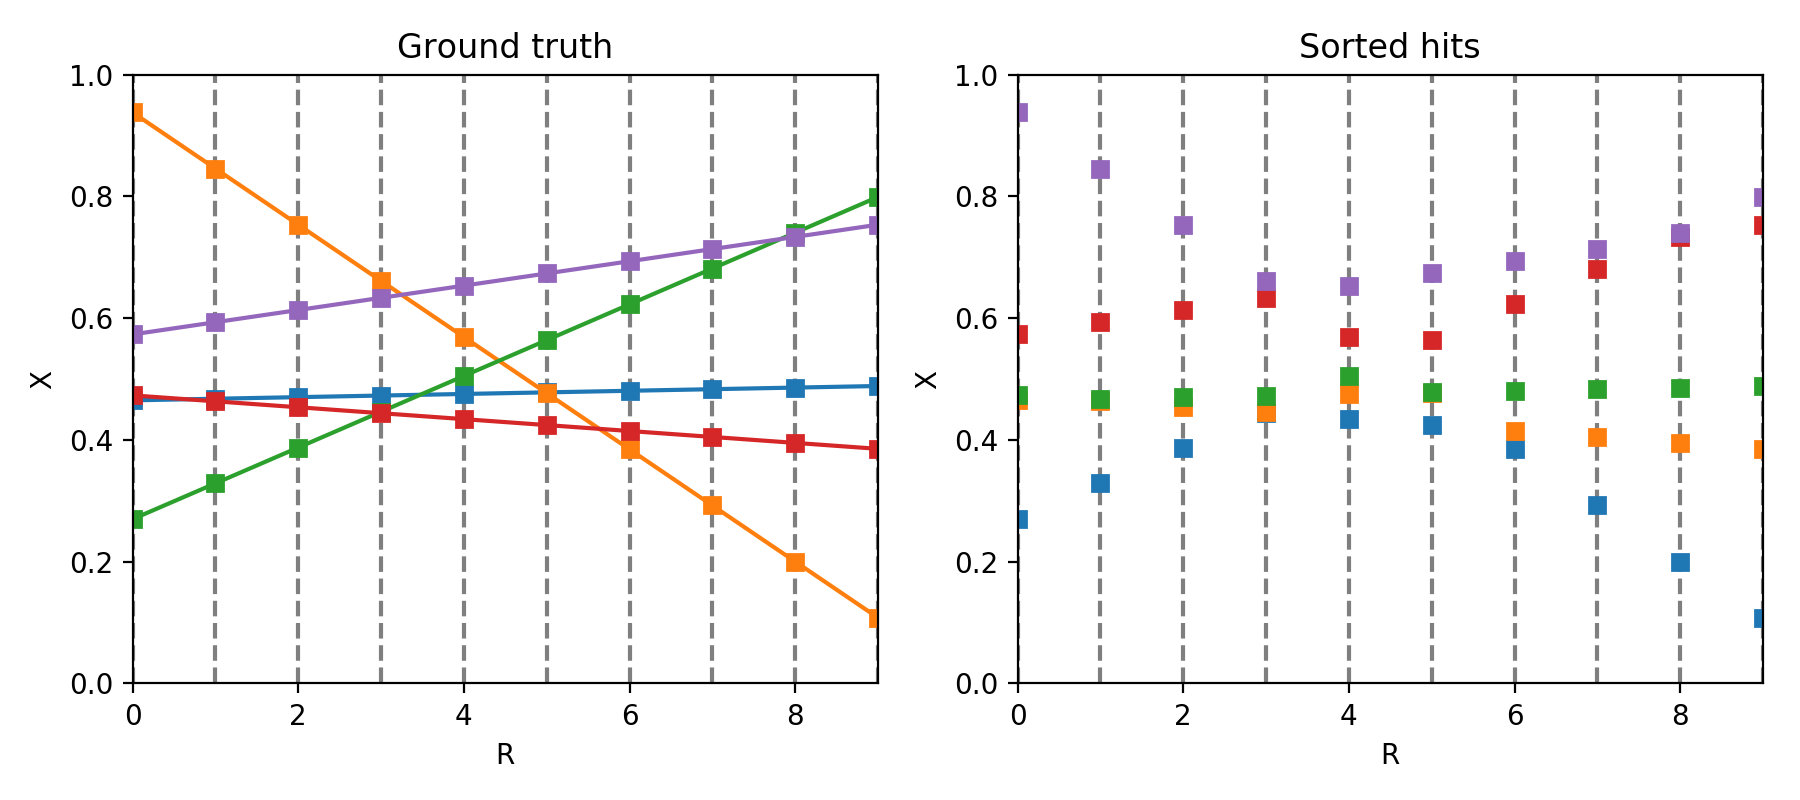

In [5]:
plt.figure(figsize=(9,4))

plt.subplot(121)
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(x.shape[0]):
    plt.plot(det_r, x[i], 's-')
plt.xlim((0, num_det_layers - 1))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.title('Ground truth')

plt.subplot(122)
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(img.shape[1]):
    plt.plot(det_r, img.T[i], 's')
plt.xlim((0, num_det_layers - 1))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.title('Sorted hits')

plt.tight_layout()

<IPython.core.display.Javascript object>


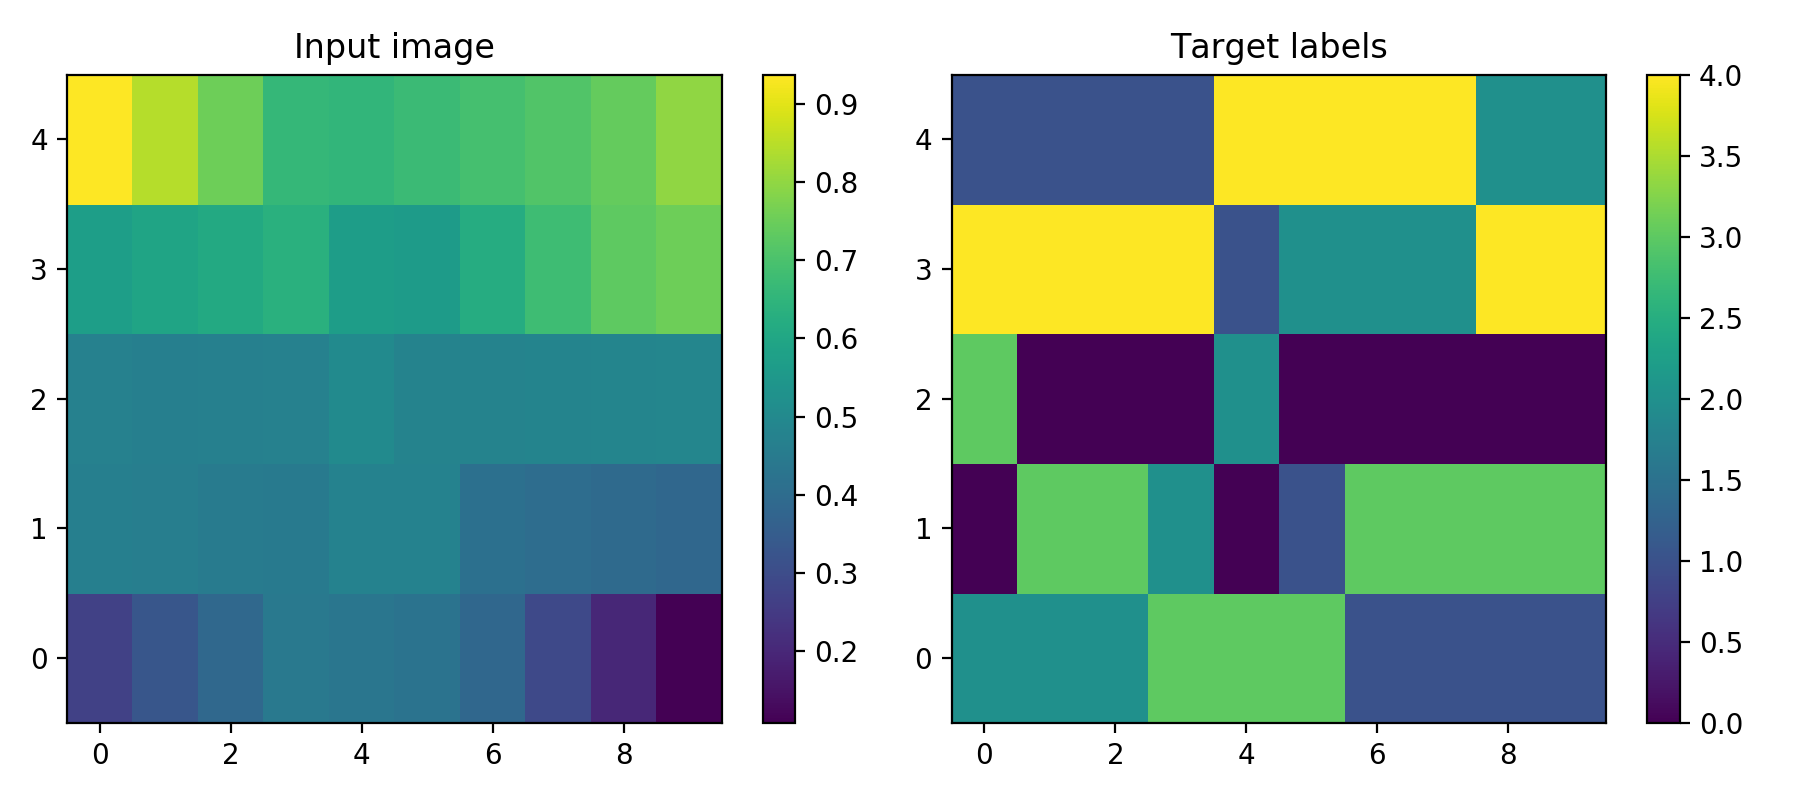

In [6]:
plt.figure(figsize=(9,4))

plt.subplot(121)
plt.imshow(img.T, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Input image')

plt.subplot(122)
plt.imshow(idx.T, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Target labels')

plt.tight_layout()

Ok, next is to setup code to generate a full set of these, or a batch sample for training.

Seeded track finding model input shape is (num_event, num_chan, num_track, num_det_layer)

In [7]:
def batch_generator(num_event, #num_channel,
                    num_track, det_r, seed_size):
    """Assume one channel for now"""
    num_det_layer = det_r.shape[0]

    while True:
        # Create the empty arrays
        model_input = np.zeros((num_event, 2, num_det_layer, num_track))
        model_target = np.zeros((num_event, num_det_layer, num_track))
        #model_input = np.zeros((num_event, num_channel + 1, num_det_layer, num_track))
        #model_target = np.zeros((num_event, num_channel, num_det_layer, num_track))
        
        # Loop over events
        for ievt in range(num_event):
            
            # Generate the tracks
            track_hits = gen_tracks(num_track, det_r)
            sorted_hits, sort_idx = transform_hits(track_hits)
            
            # Fill the input hit coordinates channel
            model_input[ievt, 0] = sorted_hits
                
            # Fill the model target
            itrk = 0
            track_target = (sort_idx == itrk).astype(np.float)
            model_target[ievt] = track_target
                
            # Fill the input seed; might want to set remaining values to 1
            model_input[ievt, 1, :seed_size] = track_target[:seed_size]
            
            # Loop over track channels
            #for itrk in range(num_channel):
                # Fill the model target
                #track_target = (sort_idx == itrk).astype(np.float)
                #model_target[ievt, itrk] = track_target
                # Fill the input seed; might want to set remaining values to 1
                #model_input[ievt, 1 + itrk, :seed_size] = track_target[:seed_size]

        yield model_input, model_target

<IPython.core.display.Javascript object>


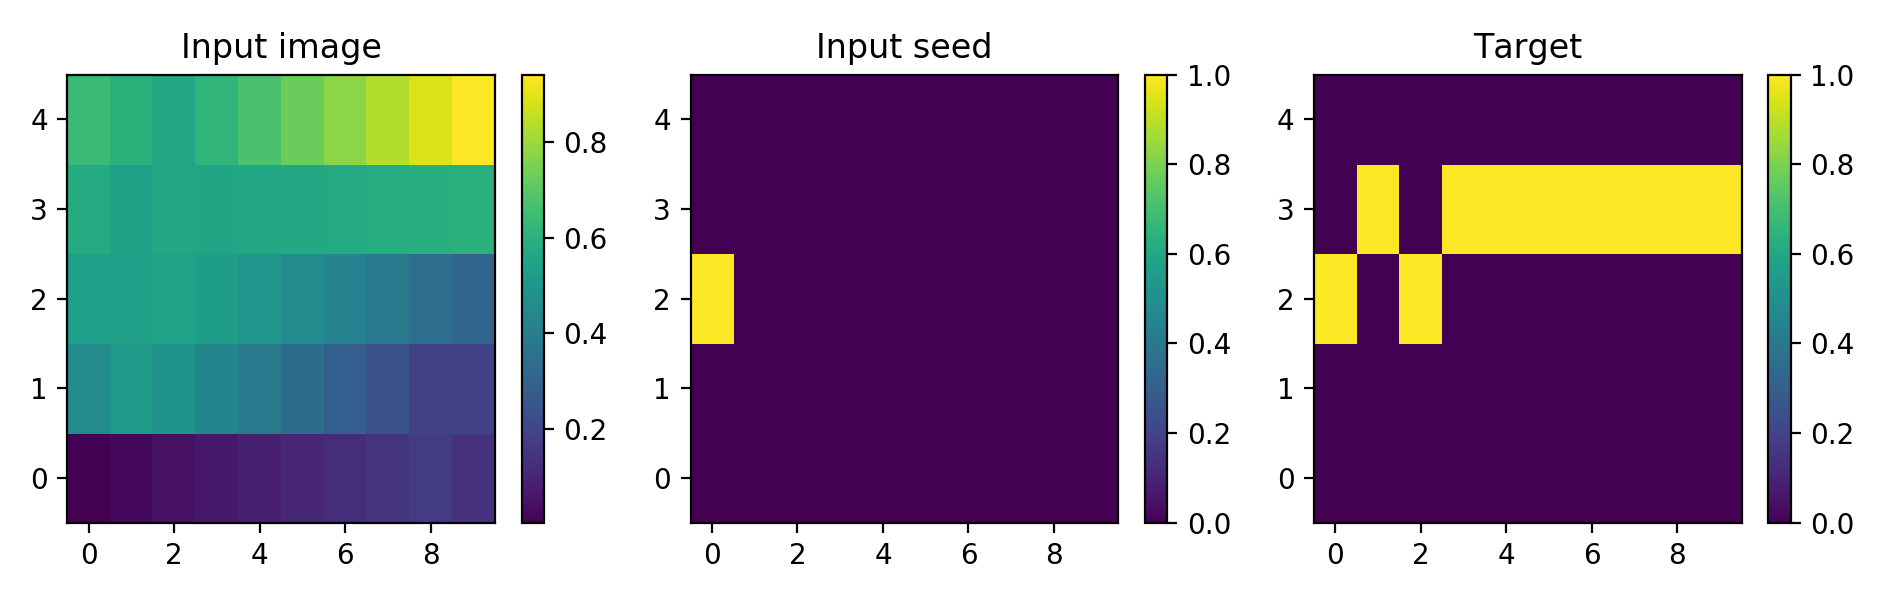

In [8]:
# Test the generator
data = batch_generator(1, 5, det_r, seed_size=1).next()
din, dout = data[0][0], data[1][0]

# Draw this event to make sure things make sense
plt.figure(figsize=(9.5, 3))

plt.subplot(131)
plt.imshow(din[0].T, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Input image')

plt.subplot(132)
plt.imshow(din[1].T, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Input seed')

plt.subplot(133)
plt.imshow(dout.T, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Target')

plt.tight_layout()

## Simple convolutional model

Now we will attempt to define a simple CNN model which operates on this data and tries to identify the target track.

In [9]:
# Updated for Keras 2 API!!!
def build_cnn(num_det_layer, num_track):
    """Assuming one output channel now for simplicity"""
    inputs = layers.Input(shape=(2, num_det_layer, num_track))
    # Keras 2
    hidden = layers.Conv2D(4, (5, 5), padding='same', activation='relu')(inputs)
    hidden = layers.Conv2D(4, (5, 5), padding='same', activation='relu')(hidden)
    hidden = layers.Conv2D(4, (5, 5), padding='same', activation='relu')(hidden)
    hidden = layers.Conv2D(1, (5, 5), padding='same')(hidden)
    #hidden = layers.Conv2D(4, 3, 3, border_mode='same', activation='relu')(inputs)
    #hidden = layers.Conv2D(4, 3, 3, border_mode='same', activation='relu')(hidden)
    #hidden = layers.Conv2D(1, 3, 3, border_mode='same')(hidden)
    hidden = layers.Reshape((num_det_layer, num_track))(hidden)
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

def build_fnn(num_det_layer, num_track):
    """Assuming one output channel now for simplicity"""
    inputs = layers.Input(shape=(2, num_det_layer, num_track))
    hidden = layers.Dense

In [25]:
# Data config
num_track = 5
num_det_layer = 10
det_r = np.arange(num_det_layer)
seed_size = 3

# Training config
batch_size = 64
epoch_size = 1024
num_epoch = 20

In [26]:
model1 = build_cnn(num_det_layer=num_det_layers, num_track=num_tracks)
model1.summary()

batcher = batch_generator(batch_size, num_track=num_tracks,
                          det_r=det_r, seed_size=seed_size)

# Keras 2 API
history1 = model1.fit_generator(batcher, epochs=num_epoch, steps_per_epoch=epoch_size)
#history1 = model1.fit_generator(batcher, samples_per_epoch=epoch_size, nb_epoch=num_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2, 10, 5)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 10, 5)          204       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 10, 5)          404       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 10, 5)          404       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 10, 5)          101       
_________________________________________________________________
reshape_4 (Reshape)          (None, 10, 5)             0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 5)             0         
Total para

In [27]:
# Generate a little test set
test_input, test_target = batcher.next()
test_pred = model1.predict(test_input)

<IPython.core.display.Javascript object>


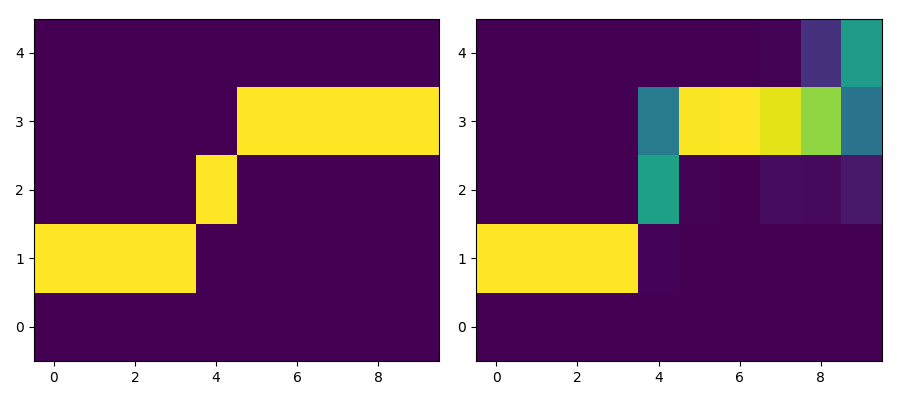

In [31]:
i = 3
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(test_target[i].T, origin='lower', aspect='auto')
plt.subplot(122)
plt.imshow(test_pred[i].T, origin='lower', aspect='auto')
plt.tight_layout()